# Identifying and measuring the properties of Giant Molecular Clouds (GMCs)


## Authors ##
[Eric Koch](https://github.com/e-koch),
...

## Learning Goals ##

* Access and extract signal in spectral line data cubes
* Demonstrate and compare how cloud identification algorithms work
* Estimate the most common measurements made for GMCs
* Compare to catalogs available from the literature to place these GMCs in broader context of the known populations

## Keywords ##

radio astronomy, spectral-line data cubes, spectral fitting, spatial fitting

## Summary ##

Summary here, with description of the data.

This tutorial builds off [example scripts](https://gist.github.com/low-sky/654819a7e5486f2c8acb6fdc5d638842) developed for Local Group and nearby galaxy studies from PHANGS written by Erik Rosolowsky.

Code for the signal masking and moment calculations are described in depth in the [radio-astro-tools tutorial library](https://radio-astro-tools.github.io/tutorials/) under "Signal-masking and calculating moment maps from spectral cube".


## Requires ##

```
pip install UPDATE HERE
```

- spectral-cube
- astrodendro
- SCIMES
- astropy
- numpy
- scikit-image

In [4]:
## For installation on google co-lab

!pip install numpy
!pip install scipy
!pip install astropy
!pip install spectral-cube
!pip install radio-beam
!pip install scikit-image

# Install most recent dev versions of astrodendro, pycprops, and SCIMES
!pip install git+https://github.com/dendrograms/astrodendro.git@main
!pip install git+https://github.com/PhangsTeam/pycprops.git@master

## NOTE: temp fix until the lastest PR is merged to the main branch
# !pip install git+https://github.com/Astroua/SCIMES.git@scimes
!pip install git+https://github.com/e-koch/SCIMES.git@master


  Cloning https://github.com/dendrograms/astrodendro.git (to revision main) to /private/var/folders/zq/1v3_7dn10sl0f6m5xqw37fvw0000gn/T/pip-req-build-i7mebiiu
  Running command git clone --filter=blob:none --quiet https://github.com/dendrograms/astrodendro.git /private/var/folders/zq/1v3_7dn10sl0f6m5xqw37fvw0000gn/T/pip-req-build-i7mebiiu
  Resolved https://github.com/dendrograms/astrodendro.git to commit 3181c36489caa4c62b36b7ec8e06f4da65af6fda
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/PhangsTeam/pycprops.git (to revision master) to /private/var/folders/zq/1v3_7dn10sl0f6m5xqw37fvw0000gn/T/pip-req-build-dho83is6
  Running command git clone --filter=blob:none --quiet https://github.com/PhangsTeam/pycprops.git /private/var/folders/zq/1v3_7dn10sl0f6m5xqw37fvw0000gn/T/pip-req-build-dho83is6
  Resolved https://github.com/PhangsTeam/pycprops.git to commit 35747c5f968a5250

In [6]:
%matplotlib inline

import numpy as np

from astropy import units as u
from astropy.wcs import wcs
from astropy.io import fits

import skimage.segmentation as seg

# from scimes import SpectralCloudstering

from astrodendro import Dendrogram

from astrodendro import ppv_catalog
from pycprops import cloudalyze


### Tutorial Dataset

The data cube we use here is an SMA observations of the $^{12}$CO(2-1) emission in a nascent tidal dwarf galaxy ("DF-E1") near M82 that was identified in deep H$\alpha$ mapping with the Dragonfly Telephoto Array ([Pasha+2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...923L..21P/abstract)).

The full set of observations is publicly accessible from the [SMA Data Archive](https://lweb.cfa.harvard.edu/sma-archive/) under project 2021B-S067.



## Loading and preparing the data

This tutorial uses the [spectral-cube](https://spectral-cube.readthedocs.io/en/latest/) package to read and manipulate the CO data cube. You can find detailed tutorials using spectral-cube on the [radio-astro-tools](https://radio-astro-tools.github.io/tutorials/) site.

In [1]:
from spectral_cube import SpectralCube

#####
# Final version of this tutorial will access this data set from the DataVerse
#####
# from astropy.utils.data import download_file

# datafile = download_file(
#     'https://dataverse.harvard.edu/api/access/datafile/10359120',
#     cache=True, show_progress=True)

datafile = "temp_data/DFE1_com_co21_5kms_natural_pbcorr.image.fits"

cube = SpectralCube.read(datafile)

cube

VaryingResolutionSpectralCube with shape=(69, 144, 144) and unit=Jy / beam:
 n_x:    144  type_x: RA---SIN  unit_x: deg    range:   149.094257 deg:  149.174504 deg
 n_y:    144  type_y: DEC--SIN  unit_y: deg    range:    69.698621 deg:   69.726427 deg
 n_s:     69  type_s: VRAD      unit_s: m / s  range:   101453.231 m / s:  397912.263 m / s

To simplify the GMC identification and analysis, we need to apply 2 preprocessing steps to this data cube.

1. Convolve to a common, circular beam (i.e., PSF): From the summary above, a `VaryingResolutionSpectralCube` means that the beam of the data varies across frequency/velocity channels. We will convolve the cube to have a common beam across channels, and circularize the beam
 
2. Convert from flux density to brightness temperature: The cube currently has units of `Jy/beam`, or a specific flux density. It is convenient to instead use brightness temperature units (using the Rayleigh-Jeans approximation) for resolved structure.

### Convolve to a circular, common beam size

The largest beam size in the cube is:

In [2]:
cube.beams.largest_beam()

Beam: BMAJ=4.380295753479004 arcsec BMIN=2.885484218597412 arcsec BPA=-48.6453857421875 deg

In this case, we will define the target resolution to be a beam with a FWHM of $4.^{''}5$, slightly larger than the current largest beam. Since we want a circular beam, we do need to specify the minor axis or position angle.

In [3]:
from radio_beam import Beam

circ_beam = Beam(4.5*u.arcsec)

cube = cube.convolve_to(circ_beam)

In [4]:
cube.beam

Beam: BMAJ=4.5 arcsec BMIN=4.5 arcsec BPA=0.0 deg

### Convert to brightness temperature units

For extended emission, it is convenient to convert the specific flux density (Jy/beam) into a surface brightness temperature (K) using the Rayleigh-Jeans approximation.

spectral-cube handles the frequency and beam dependence of the data, so we only need to call `.to(u.K)`:

In [5]:
cube = cube.to(u.K)

cube

SpectralCube with shape=(69, 144, 144) and unit=K:
 n_x:    144  type_x: RA---SIN  unit_x: deg    range:   149.094257 deg:  149.174504 deg
 n_y:    144  type_y: DEC--SIN  unit_y: deg    range:    69.698621 deg:   69.726427 deg
 n_s:     69  type_s: VRAD      unit_s: m / s  range:   101453.231 m / s:  397912.263 m / s

And for convenience, we will convert the spectral axis to km/s:

In [29]:
cube = cube.with_spectral_unit(u.km / u.s)

cube

SpectralCube with shape=(69, 144, 144) and unit=K:
 n_x:    144  type_x: RA---SIN  unit_x: deg    range:   149.094257 deg:  149.174504 deg
 n_y:    144  type_y: DEC--SIN  unit_y: deg    range:    69.698621 deg:   69.726427 deg
 n_s:     69  type_s: VRAD      unit_s: km / s  range:      101.453 km / s:     397.912 km / s

### Quicklook at the data

To get an initial sense of what is in these data, we will make 2 "quicklook" images of the peak temperature (maximum along the spectal axis) and extract a representative spectrum at a location where we see emission in the peak temperature map.

To make the peak temperature map, we find the maximum along the spectral (`axis=0`) dimension:

/Users/ekoch/Library/CloudStorage/Dropbox/code_development/radio_astro_tools/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


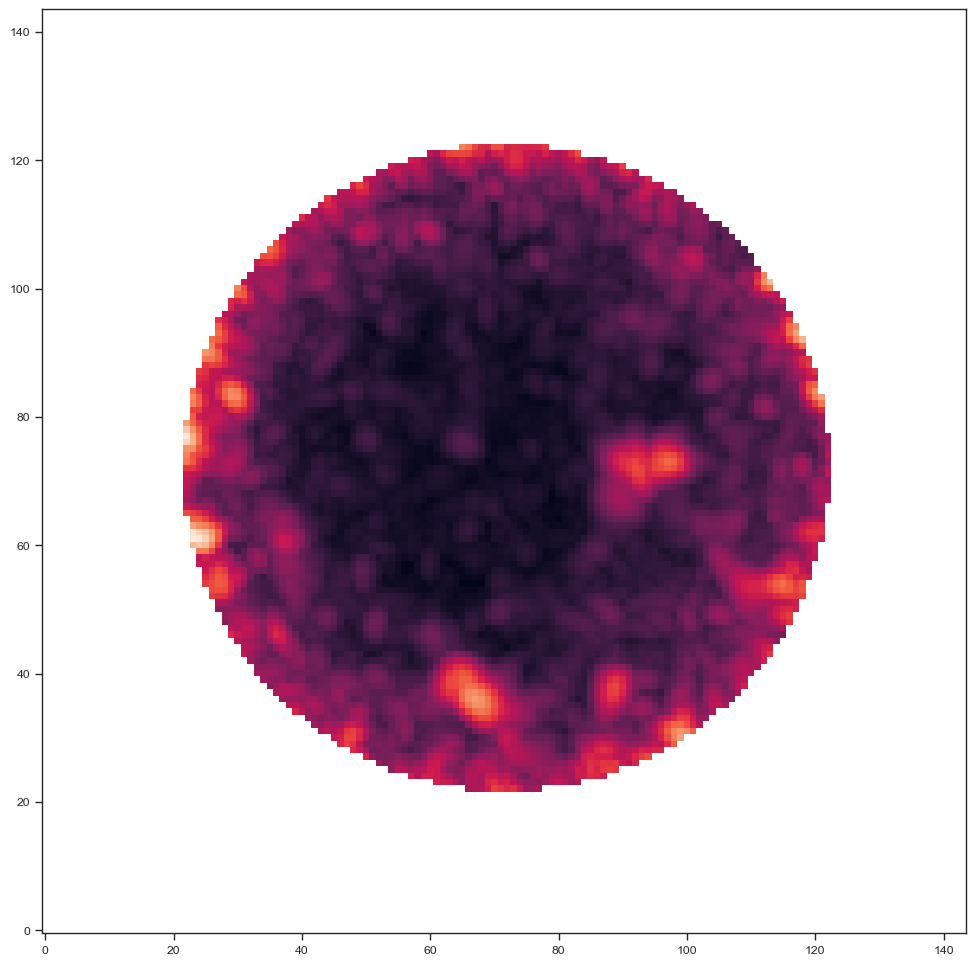

In [30]:
tpeak = cube.max(axis=0)

plt.figure(figsize=(12, 12))
plt.imshow(tpeak.value, origin='lower')

There are several bright "blobs" towards the center of the field (as well as along the edge; we will come back to this in the signal identification section below).

The axes are in pixel units. We will select `70, 90` in (y, x) to check what an individual spectrum looks like in the more central blob.

To do this, we treat the cube like a numpy array by slicing out a single 1D array from the 3D structure 

.. note:: *note that the axes are consistently in order of (spectral, declination, right ascension) for WCS coordinates defined with N in the +y direction.*

Text(0.5, 0, 'Velocity (km/s)')

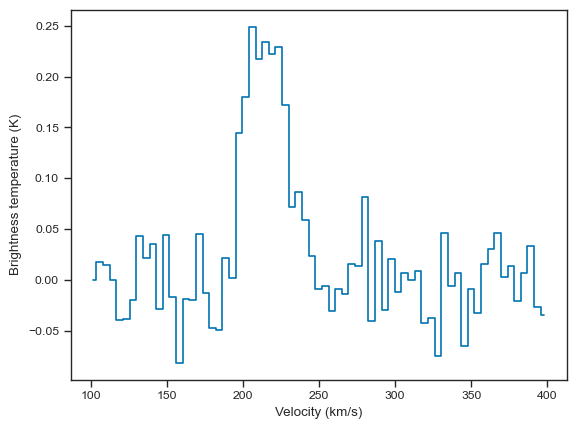

In [31]:
ypix, xpix = 70, 90

# The axis order is: velocity, y=declination, x=right ascension
spec = cube[:, ypix, xpix]

# Along x-axis, extract the spectral axis and convert the units from m/s to km/s
# We use ".value" as these are defined as an astropy quantity with a specific unit.
# Some versions of matplotlib do not handle the units well. (you may or may not need this)
plt.plot(spec.spectral_axis.to(u.km / u.s).value,
         spec.value, drawstyle='steps-mid')

plt.ylabel('Brightness temperature (K)')
plt.xlabel("Velocity (km/s)")

There is a clear detection with a Gaussian-like shape! This is the signal we want to separate from the noise only component in the data.

To do this, we will use morphological operators to create a boolean mask defining where the CO emission is located.

### Making the signal mask

As the plots above show, we only expect a few regions, isolated in velocity, to be "real" emission. The remaining parts of the field are dominated by noise.

To separate the regions with and without signal, we will use a standard masking routine often used with spectral line data cubes. 

**NOTE** The code for the signal masking and moment calculations are described in depth in the [radio-astro-tools tutorial library](https://radio-astro-tools.github.io/tutorials/) under "Signal-masking and calculating moment maps from spectral cube". See that tutorial for further details.


First, we need to estimate how the noise varies spatially across the map:

In [32]:
cube_sclip = cube.sigma_clip_spectrally(3) # Clip and mask values above 3-sigma

mad_std_map_sclip = cube_sclip.mad_std(axis=0) # Calculate sigma along the spectral dimension

# The warnings that pop up are OK to ignore.

/Users/ekoch/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


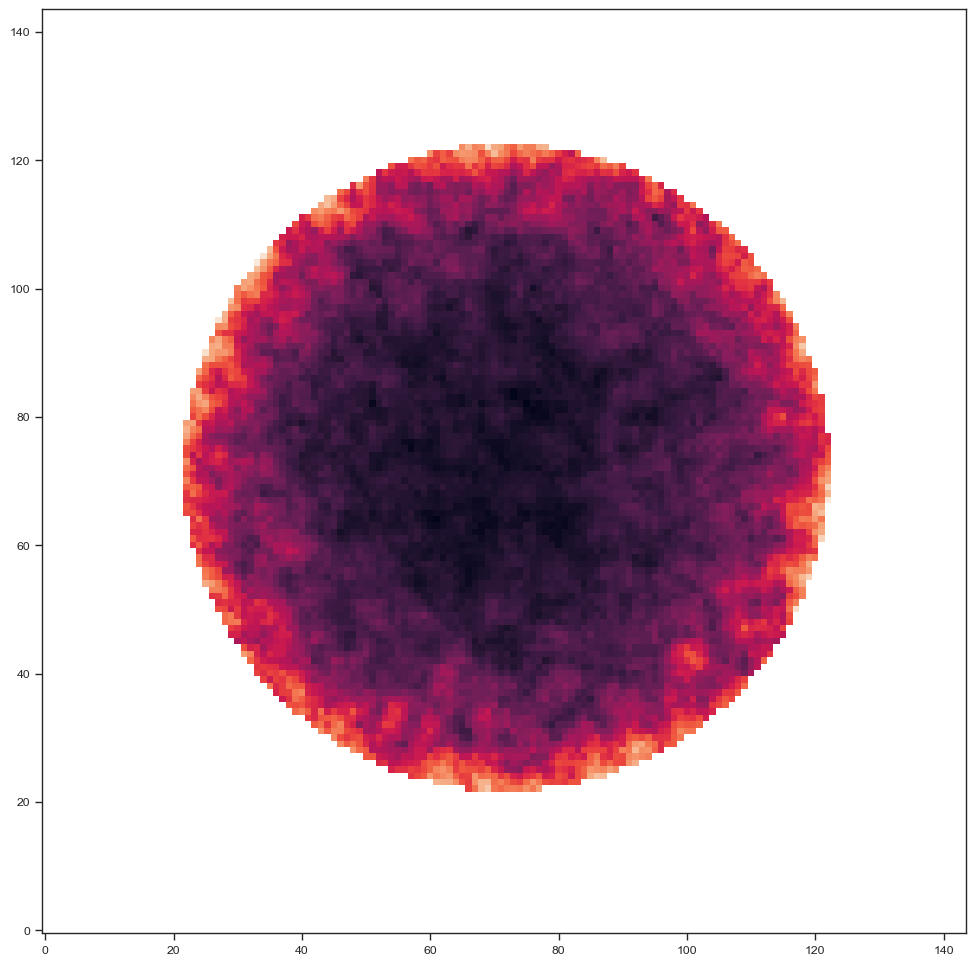

In [33]:
plt.figure(figsize=(12, 12))

plt.imshow(mad_std_map_sclip.value, origin='lower')

Here we can see our expected noise behaviour: the noise level grows with the distance away from the center of the telescope pointing, following an approximately 2D Gaussian response function.

We will use this noise map to create a signal mask of the 12CO emission.

We will also use this when estimating the uncertainties in the cloud properties, and so we will save this noise map in another FITS file. Assuming the noise is constant along the velocity axis, we will expand the 2D noise map from above into the original 3D for use with the pycprops algorithm:

In [34]:
noise_cube_hdu = fits.PrimaryHDU(np.tile(mad_std_map_sclip.value, (cube.shape[0], 1, 1)),
                             cube.header)

noise_filename = "temp_data/DFE1_com_co21_5kms_natural_pbcorr.image.K.noise.fits"
noise_cube_hdu.writeto(noise_filename, overwrite=True)


In this example, we will use one of the most common signal identification techniques outlined in [Rosolowsky & Leroy (2006)](https://ui.adsabs.harvard.edu/abs/2006PASP..118..590R/abstract) (amongst others).

This technique defines two initial masks:

1. A low signal mask that includes more signal but is affected by spurious noise. Here we use $>3\sigma$.
2. A high signal mask that includes less signal but is not less affected by noise. Here we use $>6\sigma$.

The goal is to identify connected regions in the low signal mask that are also in the high signal mask, and remove those that are only in the low signal mask as those are more likely to be spurious peaks in the noise.

In [35]:
# Make a low and high mask
# The ".include()" returns a 3D boolean mask.
low_snr_mask = (cube > 3 * mad_std_map_sclip).include()
high_snr_mask = (cube > 5 * mad_std_map_sclip).include()

Here we have defined an "inclusion" mask, meaning `True` in the mask are pixels we are interested in operating on. With spectral-cube's masks, the inclusion mask is returned as an array using `.include()`.

Next, we will label connected regions in `low_snr_mask` and label them. `low_snr_mask` and `high_snr_mask` are both dask arrays. We define regions as connected as 26-connected, meaning all edge and corner connections are included in 3D. The equivalent in 2D is 8-connected and would have a structure element like:

```
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
```

In this example, we will use the [scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html) package that provides morphological operations for numpy arrays.

In [36]:
import scipy.ndimage as nd

structure = np.ones((3, 3, 3), dtype=bool)

low_snr_mask_labels, num_labels = nd.label(low_snr_mask,
                                           structure=structure)

print(f"Initial number of regions found: {num_labels}")

Initial number of regions found: 347


That's a LOT of regions. Far more than is suggested compared to the Tpeak map above. We only expect a few real regions of signal based on the peak intensity map from above.

Most of the regions are small, spurious regions due to noise. To remove these, we will apply 2 criteria:

1. All regions in `low_snr_mask` must contain $>5$ pixels above $6\sigma$ (the `high_snr_mask`). To do this, we calculate the sum of `high_snr_mask` within the `low_snr_mask_labels`.
2. Regions in `low_snr_mask` must contain $>40$ pixels. Similarly, we calculate the sum of `low_snr_mask` within the `low_snr_mask_labels`.

Regions that do not satisfy these criteria are removed from the mask.

The exact number of pixels for each criteria are approximate only and determined by checking different thresholds. A good rule-of-thumb is for regions in `low_snr_mask` to be greater than the number of pixels in the beam. $30$ pixels is approximately the number of pixels within the FWHM of the beam for these data based on the size of the beam, and so is the minimum number we expect for real signal within 1 spectral channel.

In [69]:
# Number of pixels per beam
ppb = cube.pixels_per_beam

int(ppb)

46

In [70]:
num_pixels_in_high_snr_mask = nd.sum(high_snr_mask,
                                     labels=low_snr_mask_labels,
                                     index=range(1, num_labels + 1)) # +1 offset for mask labels

# Repeat for the high signal mask.
num_pixels_in_low_snr_mask = nd.sum(low_snr_mask,
                                    labels=low_snr_mask_labels,
                                    index=range(1, num_labels + 1)) # +1 offset for mask labels

# To preserve the low_snr_mask, we will create a new signal mask where we will remove
# regions that do not pass the criteria.
signal_mask = low_snr_mask

low_min_pixels = int(ppb)
high_min_pixels = 10

for num, (high_pix_num, low_pix_num) in enumerate(zip(num_pixels_in_high_snr_mask, num_pixels_in_low_snr_mask)):
    if high_pix_num >= high_min_pixels and low_pix_num >= low_min_pixels:
        # This region passes the criteria. Keep it in the mask.
        continue

    # Remove regions that do not pass the criteria.
    # NOTE: enumerate will start with 0, but the mask labels start at 1
    # We apply a +1 offset to `num` to account for this.
    signal_mask[low_snr_mask_labels == num + 1] = False

To find the final number of regions containing real signal, we will label the final `signal_mask`.

In [71]:
signal_mask_labels, num_labels = nd.label(signal_mask,
                                          structure=structure)

print(f"Final number of regions found: {num_labels}")

Final number of regions found: 3


Nearly every region we initially found was likely spurious, and only a few regions remain.

Before examining this new signal mask, we can apply an additional step to improve the recovery of faint emission near bright signal. Because we have imposed at $>3\sigma$ criterion in the low signal mask, some faint emission adjacent to the signal will be excluded and we will underestimate properties like the integrated intensity.

One simple way to correct for this is to extend the signal mask immediately around our remaining regions. We can extend the mask by one pixel in each dimension using [binary dilation](https://en.wikipedia.org/wiki/Dilation_%28morphology%29) to superimpose a structure element around every pixel included in the mask.

In [76]:
# Use a structure that will increase the mask size by 1 pixel in each direction.
# Because we are applying it to the 3D cube, we need its size to be (3, 3, 3):

# In the spatial dimension, expand by 1 pixel in each direction.
# The structure looks like:
# [1, 1, 1]
# [1, 1, 1]
# [1, 1, 1]
structure = np.ones((3, 3), dtype=bool)

# In the spectral dimension, only expand the original pixel along the spectral dimension.
# The structure looks like:
# [0, 0, 0]
# [0, 1, 0]
# [0, 0, 0]

structure_spec = np.zeros((3, 3), dtype=bool)
structure_spec[1, 1] = True

# Add 1 spectral element on each side of the spatial structure.
# np.dstack stacks the arrays along a new 3rd dimension:
structure = np.swapaxes(np.dstack([structure_spec, structure, structure_spec]), 2, 0)

signal_mask = nd.binary_dilation(signal_mask, structure=structure, iterations=2)

signal_mask_labels, num_labels = nd.label(signal_mask,
                                          structure=structure)

In [77]:
masked_cube = cube.with_mask(signal_mask)

/Users/ekoch/Library/CloudStorage/Dropbox/code_development/radio_astro_tools/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,
/var/folders/zq/1v3_7dn10sl0f6m5xqw37fvw0000gn/T/ipykernel_23801/2491890605.py:17: UserWarning: The following kwargs were not used by contour: 'label'
  contours.append(plt.contour(np.any(signal_mask_labels == num, axis=0),


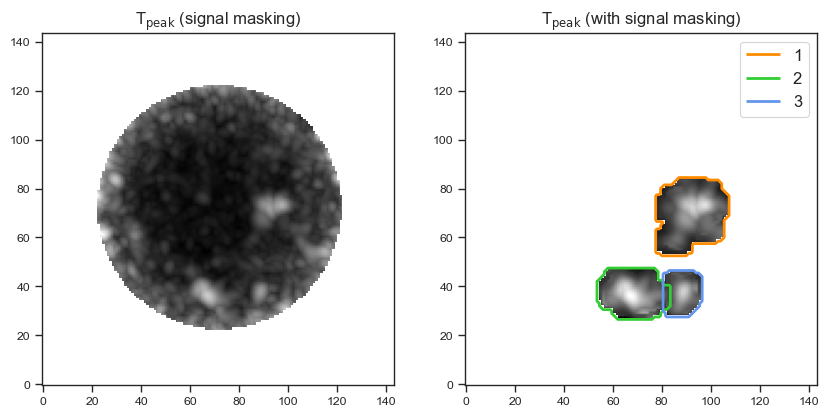

In [115]:
tpeak_signal = masked_cube.max(axis=0)

plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.title(r"T$_{\rm peak}$ (signal masking)", fontsize=12)
plt.imshow(tpeak.value, origin='lower', cmap='gray')

plt.subplot(122)
plt.title(r"T$_{\rm peak}$ (with signal masking)", fontsize=12)
plt.imshow(tpeak_signal.value, origin='lower', cmap='gray')

colors = ['darkorange', 'limegreen', 'cornflowerblue']
contours = []

for num in range(1, num_labels+1):
    contours.append(plt.contour(np.any(signal_mask_labels == num, axis=0),
                                levels=[0.5], colors=colors[num-1],
                                linewidths=2., label=f"{num}"))

plt.legend([val.legend_elements()[0][0] for val in contours],
           list(range(1, num_labels+1)),
          fontsize=12)
    

Next, we will visualize the mean spectra of each of the 3 labeled regions. While cumbersome for large numbers of regions, the mean spectrum can be a useful check to ensure the signal looks "real."

In the case of CO lines tracing molecular clouds, the line width is dominated by turbulent motions that (over a huge number of emitting CO molecules) is randomized. Thus we expect a Gaussian-like profile.

/Users/ekoch/Library/CloudStorage/Dropbox/code_development/radio_astro_tools/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/radio_astro_tools/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/radio_astro_tools/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,


Text(0, 0.5, 'Brightness Temperature (K)')

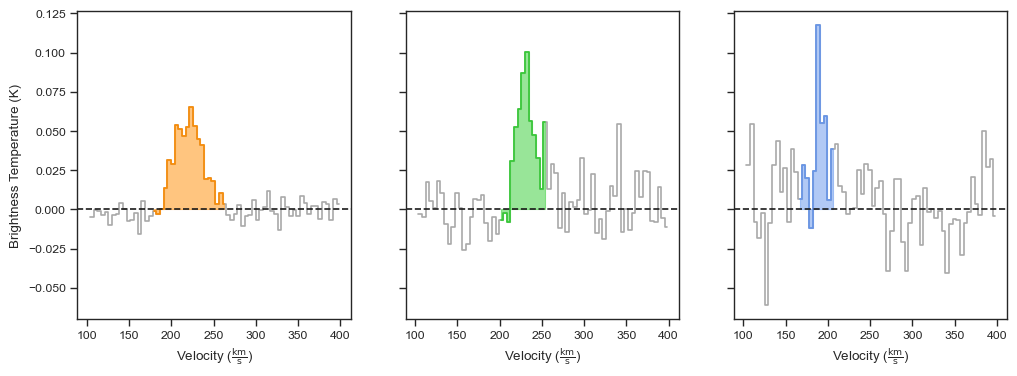

In [116]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True,
                       figsize=(12, 4))

# Redefine the color list from above (just for clarity)
colors = ['darkorange', 'limegreen', 'cornflowerblue']

for num in range(1, num_labels+1):
    
    # Identify the spatial extent of the cloud in the signal mask
    spatial_mask = np.any(signal_mask_labels == num, axis=0)
    # Identify the spectral extent of the cloud in the signal mask
    spectral_mask = np.any(signal_mask_labels == num, axis=(1, 2))
        
    # Cut the cube down to that spatial range of each clouds
    per_cloud_cube = cube.with_mask(spatial_mask).minimal_subcube(spatial_only=True)

    # Calculate the mean CO spectrum over the spatial bounding box
    mean_spec = per_cloud_cube.mean(axis=(1, 2))
        
    # -1 since we're matching to the cloud labels that start at 1 (not 0)
    ax = axs[num-1]

    # Plot the whole mean spectrum
    ax.plot(mean_spec.spectral_axis,
            mean_spec.filled_data[:].value,
            drawstyle='steps-mid',
            color='darkgray')

    # Overplot the velocity range included in the spectral dimension
    this_color = colors[num-1]
    ax.plot(mean_spec.spectral_axis[spectral_mask],
            mean_spec.filled_data[spectral_mask].value,
            drawstyle='steps-mid',
            color=this_color)
    ax.fill_between(mean_spec.spectral_axis[spectral_mask],
            mean_spec.filled_data[spectral_mask].value,
            step='mid', color=this_color, alpha=0.5)

    # And a horizontal line at 0 for reference
    ax.axhline(0., color='k', linestyle='--')
    
    
    this_spec_unit = mean_spec.spectral_axis.unit.to_string(format='latex')
    ax.set_xlabel(f"Velocity ({this_spec_unit})")

axs[0].set_ylabel(f"Brightness Temperature ({mean_spec.unit})")

The first two regions are clearly detected. The third appears to be a more marginal detection, but the coherent signal across multiple channels suggests it could be real emission, and so we will include all 3 sources in the GMC analysis.

## Making the dendrogram

Next we will construct a hierarchical structure to define the clouds and their properties. To this, we will use the [`astrodendro`](https://dendrograms.readthedocs.io/en/stable/index.html) package that implements a version of the dendrogram algorithm that can be applied to spectral line data cubes. See [the documentation](https://dendrograms.readthedocs.io/en/stable/algorithm.html#accounting-for-noise) for an overview of the parameters in the dendrogram and [Rosolowsky et al. 2008](https://ui.adsabs.harvard.edu/abs/2008ApJ...679.1338R/abstract) for a full description of the algorithm.

The user parameters can be set in terms of the signal-to-noise ratio (see [the documentation](https://dendrograms.readthedocs.io/en/stable/algorithm.html#accounting-for-noise)). To find a representative noise level, we will re-use the noise map calculated above and estimate the noise near the center of the map where the sensitivity is highest:

In [117]:
# Estimate a representative median noise level based on the center of the noise map:

pix_cent_x = mad_std_map_sclip.shape[1] // 2
pix_cent_y = mad_std_map_sclip.shape[0] // 2
box_size = 30

medrms = np.nanmedian(mad_std_map_sclip[pix_cent_y-box_size:pix_cent_y+box_size, 
                                        pix_cent_x-box_size:pix_cent_x+box_size])

medrms

<Quantity 0.0376502 K>

There are 3 parameters to set for the dendrogram algorithm:

1. `min_value`: the minimum value in the data to consider. Typically this can be some S/N level relative to the noise. Normally, we default choice of $2\sigma$ or higher is a sensible starting place. In our case, we already computed a signal mask that defined where real signal is most likely, and hence, we will set the `min_value=0`.
2. `min_delta`: the minimum difference between data to consider for the hierarchical structure. This parameter is what defined where the dendrogram tree splits into `branches` and `leaves`. Similar to `min_value`, we will use $2\sigma$ for the minimum difference.
3. `min_npix`: the minimum number of pixels in the cube for a structure to be considered "real." This parameter will reject structures that satisfy `min_delta` but contain few pixels and thereby is likely a noise spike. We will use the number of pixels in the beam as the minimum size, corresponding to the expected area of a point source.

**NOTE:** Since our signal mask above already defined the likely real sources, we are setting `min_value=0` to include all pixels in the dendrogram that remain in the signal-masked data.

**NOTE:** The `cube` with spectral-cube has a defined unit using [astropy.units](https://docs.astropy.org/en/stable/units/index.html). astrodendro does not currently support units, and thus we pass a version of the masked data without units (i.e., as a normal numpy array) with `masked_cube.unitless_filled_data[:]`.

In [121]:
from astrodendro import Dendrogram

d = Dendrogram.compute(masked_cube.unitless_filled_data[:],
                       min_value=0.,  # noise estimate
                       min_delta=2*medrms.value,
                       min_npix=1.0 * ppb, # pixels-per-beam
                       verbose=False)  # True will enable a progress bar. However, it is not formatted for notebooks.

We can visualize the dendrogram structure using [`Dendrogram.plotter()`](https://dendrograms.readthedocs.io/en/stable/api/astrodendro.plot.DendrogramPlotter.html). See the [plotting documentation](https://dendrograms.readthedocs.io/en/stable/plotting.html) for additional examples.

Text(0, 0.5, 'Brightness Temperature (K)')

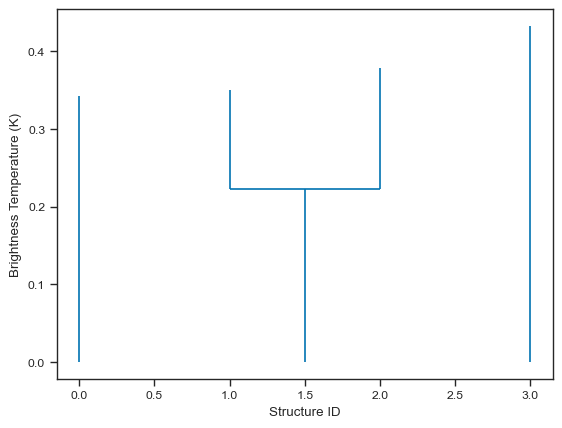

In [127]:
ax = plt.subplot(111)

dendro_plot = d.plotter()
dendro_plot.plot_tree(ax)

ax.set_xlabel("Structure ID")
ax.set_ylabel(f"Brightness Temperature (K)")

The tree structure is largely what we expect from the peak temperature maps above: 3 distinct regions. One structure (label 1 from above) has additional substructure above the noise, and so the dendrogram algorithm has split the connected regions into two `leaves` connected by a branch.

Next we can visualize which structure ID corresponds to the regions labeled above from the signal masking procedure. Structure IDs can be extracted from the dendrogram using a similar syntax you would use for a list.

In [136]:
print(len(d))

print(d[0], d[0].idx)

5
<Structure type=branch idx=0> 0


Why 5 structures? Each branch and leaf is counted as a structure in the tree, and hence the middle structure counts for 3 (branch, leaf, leaf).

The relationship between structures is defined as the `parent` and `children` properties of a branch

In [134]:
this_branch = d[0]

print(this_branch.parent)

print(this_branch.children)

None
[<Structure type=leaf idx=2>, <Structure type=leaf idx=3>]


In this case, the branch is the "trunk" of the structure and has no parent structure. The two leaves on the branch are its children structures (idx 2 and 3)

With a clearer picture of what is in the dendrogram structure, we can next extract the regions of each on the original map. To do this, each structure has a `.get_mask` function that returns a boolean mask with the same shape as the original data cube where `True` defines the pixels inside that structure.

/var/folders/zq/1v3_7dn10sl0f6m5xqw37fvw0000gn/T/ipykernel_23801/1637582728.py:12: UserWarning: The following kwargs were not used by contour: 'linestyle'
  plt.contour(np.isfinite(cube[0]), levels=[0.5], colors='gray', linestyle='--')
/var/folders/zq/1v3_7dn10sl0f6m5xqw37fvw0000gn/T/ipykernel_23801/1637582728.py:23: UserWarning: The following kwargs were not used by contour: 'label'
  contours.append(plt.contour(np.any(this_mask, axis=0),


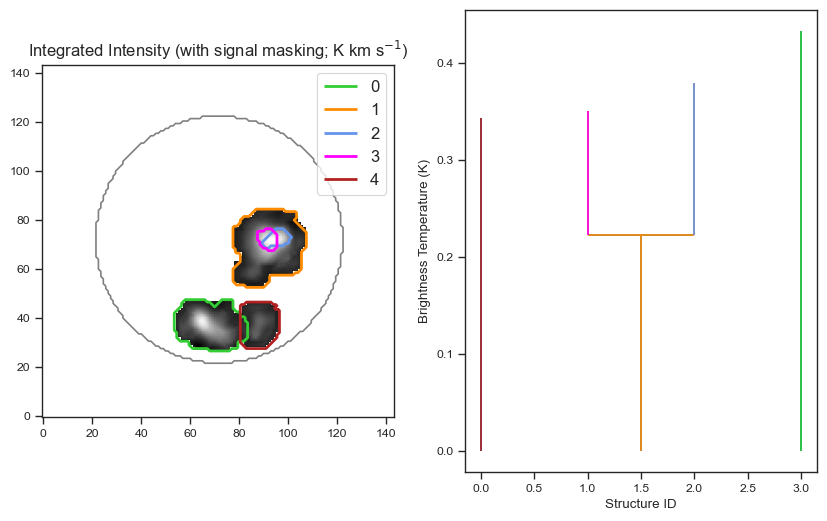

In [143]:
# Plot the masked moment 0 maps

moment0_signal = masked_cube.moment0()

plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.title(r"Integrated Intensity (with signal masking; K km s$^{-1}$)", fontsize=12)
plt.imshow(moment0_signal.value, origin='lower', cmap='gray')

# Show the field of view of the original data, for reference
plt.contour(np.isfinite(cube[0]), levels=[0.5], colors='gray', linestyle='--')


# Loop through and plot all the structures

colors = ['darkorange', 'limegreen', 'cornflowerblue', 'magenta', 'firebrick']
contours = []

for this_struct in d:
    idx = this_struct.idx
    this_mask = this_struct.get_mask()
    contours.append(plt.contour(np.any(this_mask, axis=0),
                levels=[0.5], colors=colors[idx],
                linewidths=2., label=f"{this_struct.idx}"))

plt.legend([val.legend_elements()[0][0] for val in contours],
           list(range(len(d))),
          fontsize=12)
    

# And plot the tree with matching colors:
ax = plt.subplot(122)

dendro_plot = d.plotter()
dendro_plot.plot_tree(ax)

ax.set_xlabel("Structure ID")
ax.set_ylabel(f"Brightness Temperature (K)")

for this_struct in d:
    dendro_plot.plot_tree(ax, structure=this_struct.idx,
                          color=colors[this_struct.idx])


Now we can more easily connect how the dendrogram tree maps back to the data.

In particular, we can visualize how the sub-structure in structure 1 corresponds to the bright peaks within the total area. We will investigate below the impact of the sub-structure on derived properties, but **it is worth always keeping mind that parent structures *include* all of the data within the children and therefore their properties are not independent.**

Often fields can become far more complex than the relatively simple example we show here, in which case the hierarchical structure can be essential for distinguishing between compact and diffuse structures.


#### Exploring the dendrogram interactively.

`astrodendro` includes an interactive plotter linking the data to the dendrogram described [here](https://dendrograms.readthedocs.io/en/stable/plotting.html#interactive-visualization).

This functionality _also_ works in the glue visualization software! See [here](https://docs.glueviz.org/en/stable/gui_guide/dendro.html) on how to use `astrodendro` in [glue](https://glueviz.org/).

### Make an initial catalog from the clustering

The remaining step is to calculate the properties of the identified regions which is done with the `ppv_catalog` function (and similarly for a dendrogram of a 2D image, you can use `pp_catalog`).

Before running the catalog, we need to pass relevant metadata on the data units, wavelength, beam properties, and the WCS information:

In [144]:
# Give relevant metadata to make the catalog

from astrodendro import ppv_catalog

metadata = {}
metadata['data_unit'] = masked_cube.unit
metadata['wavelength'] = (299492758 * u.m /u.s / (230.530 * u.GHz)).to(u.m)
metadata['beam_major'] =  cube.beam.major.to(u.deg)
metadata['beam_minor'] =  cube.beam.major.to(u.deg)
metadata['spatial_scale'] = cube.header['CDELT2'] * u.deg
metadata['wcs'] = cube.wcs

cat = ppv_catalog(d, metadata)

Computing catalog for 5 structures

[========>                                ] 20%
[================>                        ] 40%
[========================>                ] 60%
[================================>        ] 80%
[========================================>] 100%
[========================================>] 100%


/Users/ekoch/anaconda3/lib/python3.8/site-packages/astrodendro/analysis.py:254: MissingMetadataWarning: vaxis (Index of velocity axis (numpy convention)) missing, defaulting to 0
  warnings.warn("{0} ({1}) missing, defaulting to {2}".format(self.key, self.description, self.default),
/Users/ekoch/anaconda3/lib/python3.8/site-packages/astrodendro/flux.py:144: UnitMetadataWarning: 'Kelvin' units interpreted as main beam brightness temperature.
  warnings.warn("'Kelvin' units interpreted as main beam brightness temperature.",
/Users/ekoch/anaconda3/lib/python3.8/site-packages/astrodendro/analysis.py:254: MissingMetadataWarning: vaxis (Index of velocity axis (numpy convention)) missing, defaulting to 0
  warnings.warn("{0} ({1}) missing, defaulting to {2}".format(self.key, self.description, self.default),
/Users/ekoch/anaconda3/lib/python3.8/site-packages/astrodendro/flux.py:144: UnitMetadataWarning: 'Kelvin' units interpreted as main beam brightness temperature.
  warnings.warn("'Kelvin' u

The output is table with calculated properties per structure:

In [145]:
cat

_idx,area_ellipse,area_exact,flux,major_sigma,minor_sigma,position_angle,radius,v_cen,v_rms,x_cen,y_cen
,deg2,deg2,Jy,deg,deg,deg,deg,,pix,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,4.8100837233131644e-06,2.881018518517202e-05,7.7424911836264565,0.001120068822511887,0.0009860750978778882,-138.56410144982394,0.0010509386156138617,222283.9375791024,3.4594025855012616,149.122604108892,69.71225952627896
1,3.472993721757053e-06,1.9358024691349178e-05,5.054879556202512,0.0011507863737571429,0.0006929650825464597,160.33548691938495,0.0008930032331878533,229557.70113927792,2.144953980064672,149.13661344466487,69.70575954744791
2,5.789610497236678e-07,2.2685185185174817e-06,0.8409295793999777,0.0004544886290017906,0.00029250169659439027,-156.21364619997,0.000364607590521484,230648.13734234826,1.2066023446032617,149.12053947020914,69.71273428000306
3,5.68518208228495e-07,2.1550925925916078e-06,0.5751526645502288,0.0004102189121569545,0.00031822241286627204,114.55994279812751,0.00036130437587989905,210893.0535613707,0.7836195007541925,149.12300085527093,69.71266852929817
4,2.283468357017435e-06,1.0472993827155708e-05,1.4080444504103735,0.0008337866210443448,0.0006288428683523887,82.37092541240321,0.000724099972635942,189716.53171830892,1.5274783831367515,149.12498784743389,69.70582965915716


### [WIP] Use SCIMES to cluster the dendrograms into "real GMCs"

In [35]:
# from scimes import SpectralCloudstering

# dclust = SpectralCloudstering(d, cat,
#                               header=cube.header,
#                               save_all_leaves=True,
#                               user_iter=10,
#                               rms=medrms)

# # Extra steps to re-label the assignment cube with the clustered ids
# # Shift to cprops expectation

# asgn = dclust.clusters_asgn.data + 1
# asgn,_, _ = seg.relabel_sequential(asgn)
# # hdu = fits.PrimaryHDU(asgn, header=rms.header)
# # hdu.writeto('filename_scimes_asgn.fits', overwrite=True)


ModuleNotFoundError: No module named 'old_spectral_embedding'

### Make the final catalog using the pypcrops approach

In [146]:
# catalog = cloudalyze(cube, asgn,
#                      distance=840 * u.kpc,
#                      alphaCO=6.7, extrapolate=True,
#                      bootstrap=0, rmstorad=1.91,
#                      noise=rms, verbose=True,
#                      channelcorr=0.0)

# # NOTE above choice of alpha_CO. Not showing a varying alpha_CO example here

# # Adding additional useful properties:
# catalog['RAD_PC'] = catalog['RAD_PC'] * (np.sqrt(2*np.log(2))
#                                          / 1.91)
# r3d = np.array((catalog['RAD_PC']**2 * 50)**(1/3))
# idx = (catalog['RAD_PC'] < 50)
# r3d[idx] = np.array(catalog[idx]['RAD_PC'])
# catalog['RAD3D_PC'] = r3d

# usf = 4902
# catalog['PRESSURE'] = (3 * catalog['MLUM_MSUN'] * catalog['SIGV_KMS']**2
#                        / (8 * np.pi * catalog['RAD3D_PC']**3) * usf)
# rho = (3 * catalog['MLUM_MSUN'] /  (8 * np.pi * r3d**3)
#        * u.M_sun / u.pc**3)  # extra factor of 2 is the mass/2
# tff = np.sqrt(3 * np.pi / (32 * con.G * rho)).to(u.Myr).value

# catalog['TFF_MYR'] = tff
# catalog['RMSTORAD'] = np.sqrt(2*np.log(2))
# catalog['SURFDENS'] = catalog['MLUM_MSUN'] / (2 * np.pi
#                                               * catalog['RAD_PC']**2)

# catalog['SIGMA0SQ'] = catalog['SIGV_KMS']**2 / catalog['RAD3D_PC']
# catalog['VIRPARAM'] = (232 * 10 * catalog['RAD3D_PC']
#                        * catalog['SIGV_KMS']**2
#                        / catalog['MLUM_MSUN'])
# catalog['MVIR_MSUN'] = (5 * 232 * catalog['RAD3D_PC']
#                         * catalog['SIGV_KMS']**2)
# catalog['ECCEN'] = np.sqrt(1 - catalog['MOMMIN_PC']**2
#                            / catalog['MOMMAJ_PC']**2)


# catalog.write('filename_scimes_props.fits', overwrite=True)


### What can we do now with this catalog?

#### Comparison to the nearby galaxy and Milky Way GMC properties